# 驱动设备

## 连接设备

In [1]:
###########################################
import time
import numpy as np
import qulab_toolbox.wavedata as WD
import matplotlib.pyplot as plt
import ctypes
import zerorpc
import math

server_ip = '192.168.1.180:8501'

dev = zerorpc.Client(timeout=60, heartbeat=None)

try:
    dev.connect('tcp://' + server_ip)
    if dev.my_status() in ['ok']:
        print('rpc connect ok')
except:
    print('rpc connect error')

rpc connect ok


## 设置奈奎斯特域

In [2]:
#DA Nyquist域，1: 第二奈奎斯特域，0：第一奈奎斯特域
Nyquist = 0
dev.rfdac_SetNyquistZone(Nyquist)
dev.rfadc_SetNyquistZone(Nyquist)


'ok'

## DA输出

In [4]:
trigger_source = 0    #触发来源，1为外部触发，0为内部触发
#如果是外部触发，如下参数不起效
trigger_us = 500      #内部触发周期，us
trigger_num = 10      #内部触发次数
trigger_continue = 1  #内部触发连续触发模式，1开启，0关闭

phase_s = 0    #初相
fout = 1000e6   #频率
replay_len = 2**15  #波形长度，单位点数，da采样率4G，每点250ps
amp = 1   #幅度

dac_data=[]
dac_data.append(phase_s)
dac_data.append(fout)
dac_data.append(replay_len)
dac_data.append(amp)

trigger_delay = 0
replay_times = 1   #da输出次数，为负时一直输出

#关闭触发响应
dev.trigger_close()

#写入DDS参数

for i in range(4):
    chennel_num = i
    dev.dac_updata(chennel_num,trigger_delay,replay_times,dac_data)

#打开触发响应
dev.trigger_ctrl(trigger_source,trigger_us,trigger_num,trigger_continue)

'ok'

## AD采集信号

In [1]:

#%%
###########################################
################  AD采集
###########################################


# 设定触发来源
trigger_source = 0  # 触发来源，1为外部触发，0为内部触发
# 如果是外部触发，如下参数不起效
trigger_us = 500  # 内部触发周期，us
trigger_num = 10  # 内部触发次数
trigger_continue = 1  # 内部触发连续触发模式，1开启，0关闭

ad_trigger_delay = 200  # AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
times = 1  # AD采集次数
save_len = 2 ** 15  #AD采集长度，单位点数，ad采样率5G，每点200ps

#关闭触发响应
dev.trigger_close()

# 写入ad工作参数
for adc_channel_num in range(4):
    dev.rd_adc_data_ctrl(adc_channel_num, ad_trigger_delay, times, save_len)

# 开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
dev.trigger_ctrl(trigger_source, trigger_us, trigger_num, trigger_continue)

time.sleep(0.1)

adc_data = []
#读取ad采集到的波形数据
for adc_channel_num in range(4):
    adc_data_buf, save_len_i = dev.rd_adc_data(adc_channel_num, times, save_len)
    adc_data.append(np.array(adc_data_buf))

# 绘出所有通道时域波形
plt.figure()
for adc_channel_num in range(4):
    plt.plot(adc_data[adc_channel_num][900:950])

# 绘制某一个通道ADC采集数据FFT波形
adc_channel_num = 3

plt.figure()
plt.plot(adc_data[adc_channel_num][:])

adc_data_w = []
data_w = np.kaiser(save_len, 8)
adc_data_w = adc_data[adc_channel_num] / times
adc_data_w = adc_data_w * data_w

fft_data = []
fft_data = (20 * np.log10(abs(np.fft.fft(adc_data_w))))

plt.figure()
plt.plot(fft_data[0:save_len // 2])

sig = max(fft_data[0:save_len // 2])
fft_data = list(fft_data)
num = fft_data.index(max(fft_data[0:save_len // 2]))
for i in range(20):
    fft_data[num+i] = 0
    fft_data[num-i] = 0
    

sig1 = max(fft_data[200:save_len // 2-200])
sfdr = sig - sig1
print('sfdr', sfdr, num)

NameError: name 'dev' is not defined

## 解模

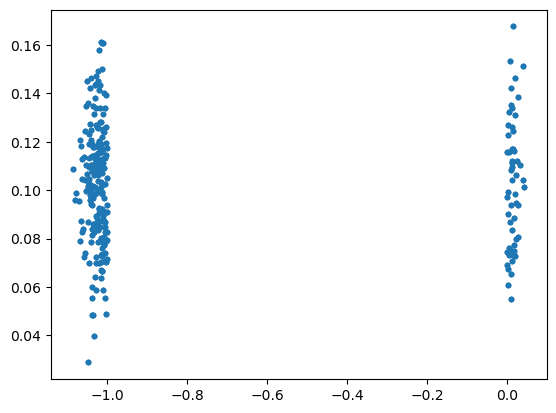

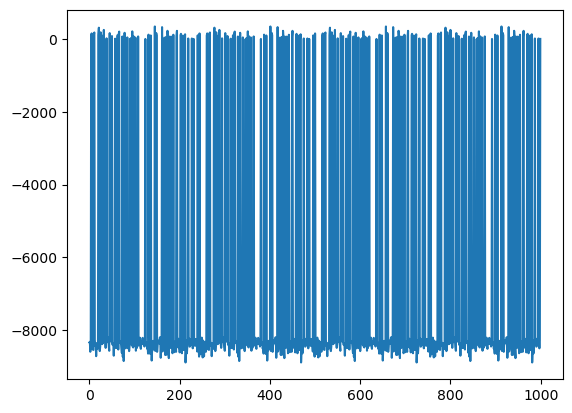

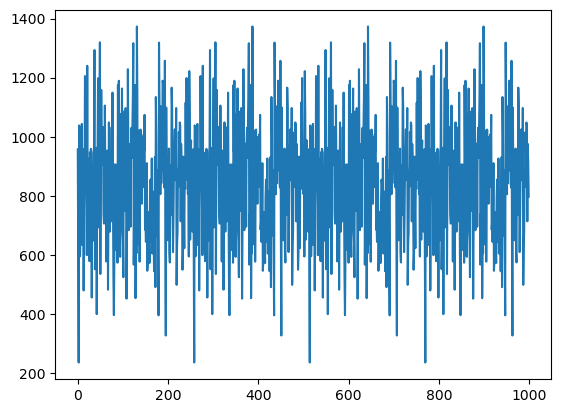

In [5]:

###########################################
################  读取
###########################################


ad_trigger_delay = 1000 #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
shots = 1000         #解模次数

mul_f = []              #解模参数列表
mul_start_phase = 0     #解模参数：初相
mul_f_freq = 1000e6     #解模参数：频率，一般每个qubit对应不同频率
mul_f_len = 2**13       #解模参数：单次解模shot数据样点数量，单位点数，ad采样率5G，每点200ps


Qbit = 1

mul_f.append(mul_start_phase)
mul_f.append(mul_f_freq)       #解模频率，实际应当按照各个qubit设定
mul_f.append(mul_f_len)        #单次解模shot数据样点数量
 
#关闭触发响应
dev.trigger_close()
    
#将解模系数写入所有读取AD通道，实际使用应当指定某一个特定ADC通道，连接到特定读取线路
for ad_channel_num in range(4):
    dev.rd_adc_mul_data_ctrl(ad_channel_num,ad_trigger_delay,shots,mul_f)

#开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
dev.trigger_ctrl(trigger_source,trigger_us,shots,trigger_continue)

#稍作延迟
time.sleep(0.1)

mul_data = []                      #解模数据存储数组
for ad_channel_num in range(4):   #ad通道
    mul_data_i = []
    for modle_num in range(Qbit):    #modle_num:解模模块通道号
        #读取当前线路所有qubit数据
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(ad_channel_num,modle_num,shots)
            if read_data_len != -1:
                break
        mul_data_bufe = list(map(complex, mul_data_bufe))
        mul_data_i.append(np.array(mul_data_bufe))
    mul_data.append(mul_data_i)



    
#绘制指定线路qubit解模结果图
ad_channel_num = 3      #显示打印图像的读取ADC通道
plt.figure()
for i in range(Qbit):
    plt.plot(mul_data[ad_channel_num][i].real/mul_f_len,mul_data[ad_channel_num][i].imag/mul_f_len,'.')

i = mul_data[ad_channel_num][0].real
q = mul_data[ad_channel_num][0].imag

plt.figure()
plt.plot(i)
plt.figure()
plt.plot(q)

0 [-2489053.47688293] [-5904230.19039536]
1 [-2485182.8903656] [-5904223.45442581]
2 [-2488130.73340225] [-5901985.93616867]
3 [-2486465.20542145] [-5905004.15570831]
4 [-2489694.32217026] [-5903700.80714417]
5 [-2488329.49768829] [-5904564.33257675]
6 [-2484005.28671646] [-5901676.51728821]
7 [-2483079.62381363] [-5904925.41214752]
8 [-2487403.60240555] [-5902230.02073669]
9 [-2484100.68114853] [-5904464.25485611]
10 [-2482857.25352097] [-5903901.23498917]
11 [-2490380.76630783] [-5902215.64648438]
12 [-2488794.61222076] [-5902367.87458801]
13 [-2482527.42485046] [-5904651.05873871]
14 [-2486775.81531906] [-5904334.34864426]
15 [-2485061.27318954] [-5903672.02041626]
16 [-2486924.29037476] [-5902420.09699631]
17 [-2493354.83314133] [-5901033.79011917]
18 [-2489765.44623184] [-5904445.84994888]
19 [-2486514.5740509] [-5905058.26449203]
20 [-2482377.62855148] [-5905207.12581635]
21 [-2484835.59175873] [-5906842.52804184]
22 [-2485350.89387131] [-5902254.35224533]
23 [-2484337.61256027] 

190 [-2489990.02445602] [-5903786.95820618]
191 [-2483670.42017746] [-5906384.89977646]
192 [-2484439.11790085] [-5903455.06552505]
193 [-2486396.42937469] [-5905539.71767807]
194 [-2487266.58293533] [-5901855.83519363]
195 [-2485110.38573456] [-5904703.13922882]
196 [-2484520.34395599] [-5905322.39419556]
197 [-2486010.74533844] [-5903321.77924347]
198 [-2490461.08836746] [-5902675.53779221]
199 [-2483197.08906174] [-5902838.89742279]


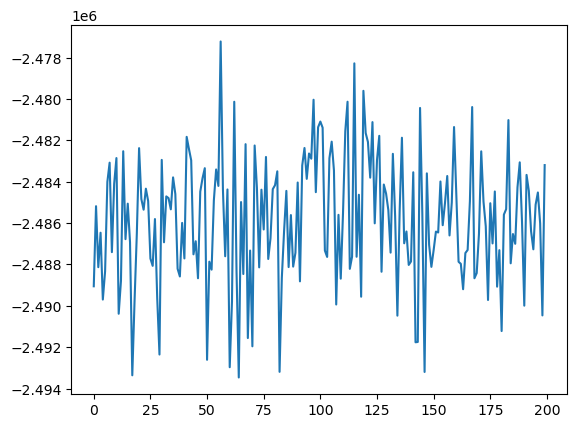

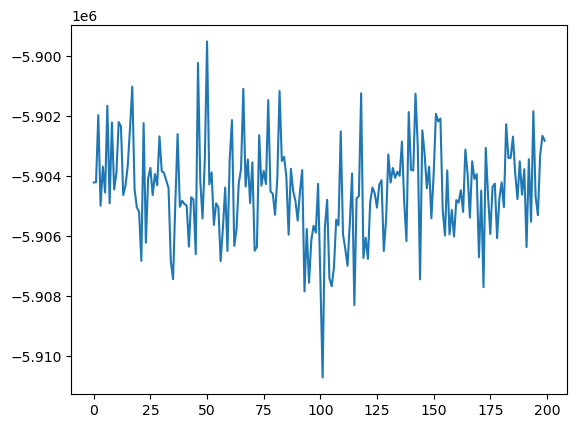

In [6]:

###########################################
################  读取
###########################################


ad_trigger_delay = 1000 #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
shots = 1         #解模次数

mul_f = []              #解模参数列表
mul_start_phase = 0     #解模参数：初相
mul_f_freq = 1000e6     #解模参数：频率，一般每个qubit对应不同频率
mul_f_len = 2**13       #解模参数：单次解模shot数据样点数量，单位点数，ad采样率5G，每点200ps


Qbit = 1

mul_f.append(mul_start_phase)
mul_f.append(mul_f_freq)       #解模频率，实际应当按照各个qubit设定
mul_f.append(mul_f_len)        #单次解模shot数据样点数量

cnt = 0
i_list = []
q_list = []
while cnt < 200:
    #关闭触发响应
    dev.trigger_close()

    #将解模系数写入所有读取AD通道，实际使用应当指定某一个特定ADC通道，连接到特定读取线路
    ad_channel_num = 0
    dev.rd_adc_mul_data_ctrl(ad_channel_num,ad_trigger_delay,shots,mul_f)

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    dev.trigger_ctrl(trigger_source,trigger_us,shots,trigger_continue)

    #稍作延迟
    time.sleep(0.1)

    mul_data = []                      #解模数据存储数组
    for ad_channel_num in range(1):   #ad通道
        mul_data_i = []
        for modle_num in range(Qbit):    #modle_num:解模模块通道号
            #读取当前线路所有qubit数据
            while 1:
                mul_data_bufe,read_data_len = dev.rd_adc_mul_data(ad_channel_num,modle_num,shots)
                if read_data_len != -1:
                    break
            mul_data_bufe = list(map(complex, mul_data_bufe))
            mul_data_i.append(np.array(mul_data_bufe))
        mul_data.append(mul_data_i)


    i = mul_data[ad_channel_num][0].real
    q = mul_data[ad_channel_num][0].imag
    i_list.append(i[0])
    q_list.append(q[0])

    print(cnt, i, q)
    cnt += 1


plt.figure()
plt.plot(i_list)
plt.figure()
plt.plot(q_list)

In [ ]:
def con_demod(channel_num, ,ad_trigger_delay, shots, mul_f):
    
    cnt = 0
    i_list = []
    q_list = []
    while cnt < shots:
        #关闭触发响应
        dev.trigger_close()

        #将解模系数写入所有读取AD通道，实际使用应当指定某一个特定ADC通道，连接到特定读取线路
        dev.rd_adc_mul_data_ctrl(ad_channel_num,ad_trigger_delay,shots,mul_f)

        #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
        dev.trigger_ctrl(trigger_source,trigger_us,shots,trigger_continue)

        #稍作延迟
        time.sleep(0.1)

        mul_data = []                      #解模数据存储数组
        mul_data_i = []
        for modle_num in range(Qbit):    #modle_num:解模模块通道号
            #读取当前线路所有qubit数据
            while 1:
                mul_data_bufe,read_data_len = dev.rd_adc_mul_data(ad_channel_num,modle_num,shots)
                if read_data_len != -1:
                    break
            mul_data_bufe = list(map(complex, mul_data_bufe))
            mul_data_i.append(np.array(mul_data_bufe))
        mul_data.append(mul_data_i)


        i = mul_data[ad_channel_num][0].real
        q = mul_data[ad_channel_num][0].imag
        i_list.append(i[0])
        q_list.append(q[0])

        print(cnt, i, q)
        cnt += 1

# 功率校准

In [96]:

da_ch = 0
ad_ch = 0

#指定环路功率校准，目前校准频率范围10~1000MHz
dev.power_calibration(da_ch, ad_ch)

'ok'

In [62]:
###  功率曲线

trigger_source = 0    #触发来源，1为外部触发，0为内部触发
#如果是外部触发，如下参数不起效
trigger_us = 500      #内部触发周期，us
trigger_num = 10      #内部触发次数
trigger_continue = 1  #内部触发连续触发模式，1开启，0关闭

dac_channel_num = 0
adc_channel_num = 0

phase_s = 0
replay_len = 2**15
amp = 0.9
da_trigger_delay = 0
replay_times = 1000

adc_data = []
ad_trigger_delay = 2000  # AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
times = 1  # AD采集次数
save_len = 2 ** 14 # AD采集点数

fs = 5e9
step = fs / save_len 
fout = step * 100

while True:
    
    dac_data = []
    dac_data.append(phase_s)
    dac_data.append(fout)
    dac_data.append(replay_len)
    dac_data.append(amp)

    dev.trigger_close()   
    dev.dac_updata(dac_channel_num,da_trigger_delay,replay_times,dac_data)
    dev.rd_adc_data_ctrl(adc_channel_num, ad_trigger_delay, times, save_len)
    dev.trigger_ctrl(trigger_source, trigger_us, times, trigger_continue)
  
    time.sleep(0.1)

    adc_data_buf, save_len_i = dev.rd_adc_data(adc_channel_num, times, save_len)
    adc_data.append(np.array(adc_data_buf))
    
    fout += step * 30

    if fout > 1000e6:
        break
    
    

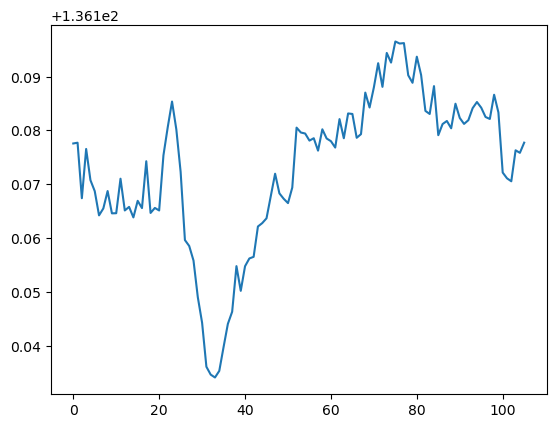

In [63]:
power = []
freq = step * 100
for i in adc_data:
    db = 20*np.log10(abs(np.fft.fft(i)))
    point = int(freq/step)
    power.append(max(db[point], db[point+1]))
    freq += step * 30
 
plt.figure()
plt.plot(power)  